# Reading shapefile data in Python

In [58]:
import shapefile
import matplotlib.pyplot as plt
import pandas as pd
import osgeo

ModuleNotFoundError: No module named 'osgeo'

In [106]:
sf = shapefile.Reader("Waterways/Hydro.shp")

In [107]:
sf.numRecords

605

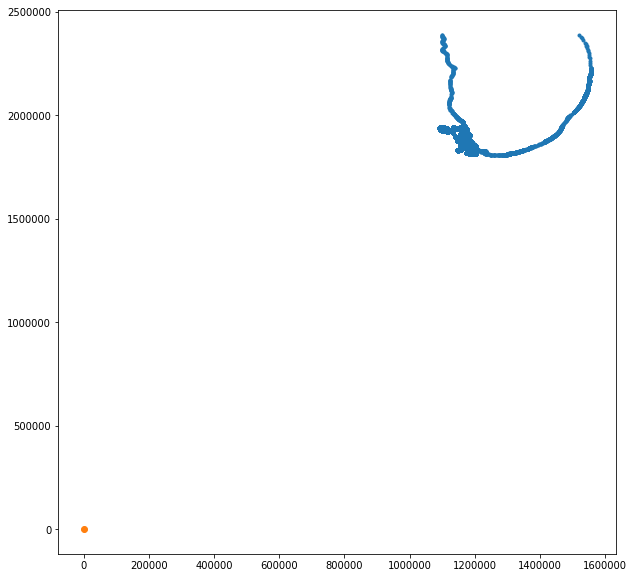

In [96]:
listx = []
listy = []
for sr in sf.shapeRecords():
    for xNew,yNew in sr.shape.points:
        listx.append(xNew)
        listy.append(yNew)

plt.figure(figsize=(10,10))        
plt.plot(listx,listy, '.')
plt.plot(0, 'o')
# plt.xlim((1050000, 1250000))
# plt.ylim((1790000, 1950000))
plt.show()


In [26]:
list1 = []
for i in range(100):
    list1.append((sf.records()[i][4],  sf.records()[i][5]))

In [31]:
trap_df = pd.read_csv("kaggle_data_download/input/train.csv")

In [33]:
trap_latlon = trap_df[['Latitude','Longitude']]

In [59]:
import pycrs

In [60]:
fromcrs = pycrs.loader.from_file("Waterways/Hydro.prj")

In [62]:
fromcrs_proj4 = fromcrs.to_proj4()

In [63]:
fromcrs_proj4

'+proj=utm +datum=NAD83 +ellps=GRS80 +a=6378137.0 +f=298.257222101 +pm=0.0  +x_0=984250.0 +y_0=0.0 +lon_0=-88.33333333333333 +lat_0=36.66666666666666 +units=us-ft +axis=enu +no_defs'

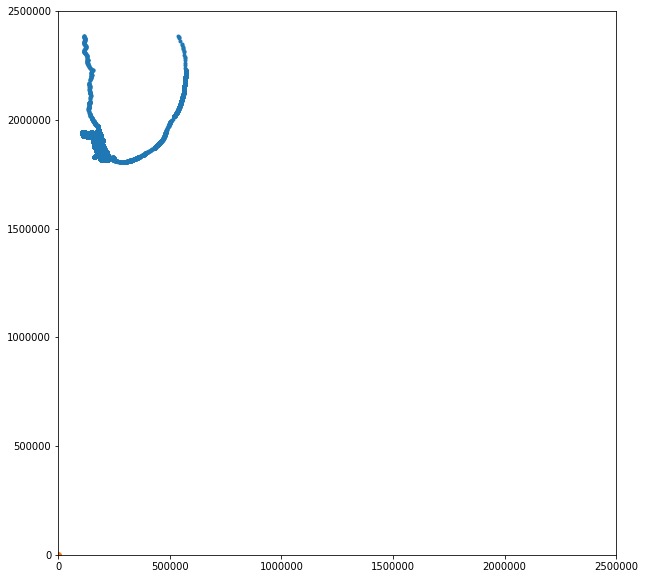

In [84]:
listx = []
listy = []
for sr in sf.shapeRecords():
    for xNew,yNew in sr.shape.points:
        listx.append(xNew - 984250.0)
        listy.append(yNew  - 0)

plt.figure(figsize=(10,10))        
plt.plot(listx,listy, '.')
plt.plot(0,'o')
plt.xlim((-4, 2500000))
plt.ylim((-4,2500000))
plt.show()

## Based on the above I believe that (0, 0) refers to the coordinates (36.666666, -88. 333333) and that the units are measured in feet.

In [128]:
def get_lat_lon(x,y):
    x0, y0 = 984250.0, 0
    lon0,lat0 = -88.333333, 36.666666
    lon_conv = 85390 # meters per degree lon at 40 north
    lat_conv = 111030 # meters per degree lat
    
    x_out = -(x0-x)*.3048/lon_conv + lon0
    y_out = (y-y0)*.3048/lon_conv + lat0
    
    return x_out, y_out

In [129]:
get_lat_lon(0, 0)

(-91.8466179279775, 36.666666)

In [133]:
lats = []
lons = []
for sr in sf.shapeRecords():
    for xNew,yNew in sr.shape.points:
        temp_tuple = get_lat_lon(xNew, yNew)
        lons.append(temp_tuple[0])
        lats.append(temp_tuple[1])

In [134]:
water_df = pd.DataFrame({
    'lat': lats,
    'lon': lons
})

water_df.to_csv("water_latlon.csv")

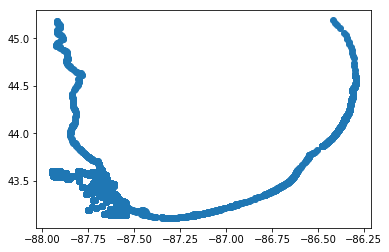

In [135]:
plt.plot(water_df['lon'], water_df['lat'], 'o')

In [137]:
def lat_lon_ds(p_1, p_2):
    """Argument 'p1' is a list of decimal [lat, lon] coords in degrees. 'p2' is another list.
    Function returns the distance between them in meters, without correction for curvature of the earth.
    Distance will be slightly underestimated by a fraction approximately (t - sin(t)), where t is the angular separation
    between the two points in radians.  For 1 degree of latitude, the relative error is < 1e-6."""
    
    import numpy as np
    
    # http://frederic.chambat.free.fr/geophy/inertie_pepi01/article.pdf
    # Equitorial radius, eqn. 15
    R_earth = 6378137  # meters
    
    # Distance btw O'Hare and Wrigley field is 20879.8 meters, along a great circle
    # coords are [41.94885800000001, 87.65774809999999], [41.9741625, 87.9073214]
    # According to http://edwilliams.org/gccalc.htm
    # This gives a Chicago-area correction factor of (20879.8/20849.9), 
    # where the denominator is calculated using uncorrected R_earth.
    
    R = R_earth*(20879.8/20849.9)
    
    theta_1 = (90 - p_1[0])*(2*np.pi/360)
    phi_1 = p_1[1]*(2*np.pi/360)
    theta_2 = (90 - p_2[0])*(2*np.pi/360)
    phi_2 = p_2[1]*(2*np.pi/360)
    
    def x(r,phi,theta):
        return r*np.sin(theta)*np.cos(phi)
    
    def y(r,phi,theta):
        return r*np.sin(theta)*np.sin(phi)
    
    def z(r,phi,theta):
        return r*np.cos(theta)
    
    # Calculate euclidean distance
    delta_s= np.sqrt(
        (x(R, phi_1, theta_1) - x(R, phi_2, theta_2))**2 + \
        (y(R, phi_1, theta_1) - y(R, phi_2, theta_2))**2 + \
        (z(R, phi_1, theta_1) - z(R, phi_2, theta_2))**2 \
    )

    return delta_s

In [148]:
def distance_to_nearest_water(lat, lon, water_list_of_tuples):
    """Takes an input lat and lon and finds the nearest lat lon in the water csv."""
    shortest_distance = 700000000
    for tup in water_list_of_tuples:
        this_dist = lat_lon_ds(list(tup), [lat, lon])
        if this_dist < shortest_distance: 
            shortest_distance = this_dist
    return shortest_distance

In [149]:
water_tups = [(lats[i], lons[i]) for i in range(len(lats))]

In [150]:
distance_to_nearest_water(-44,36,water_tups)

11982610.033104317